We have been provided with price and financial data for 100 US stocks. <br>
We need to generate 1 day ahead trading signals for each stock. We must select the ten best stocks each day to form a portfolio. <br>
The performace of the portfolio will be evaluated based on the total return index over the evaluation period. 

This is known as swing trading.
1. We are only allowed long positions. 
2. The matrix of buys will only contain 1's and 0's

In [ ]:
import pandas as pd #for manipulating data
import numpy as np #for data operations
import matplotlib.pyplot as plt #for plotting how much money the portfolio makes

In [ ]:
#next we want to load the data
#data0 contains security sector data
#data1 contains price, historical returns, financial ratios and the 1 day ahead price change label

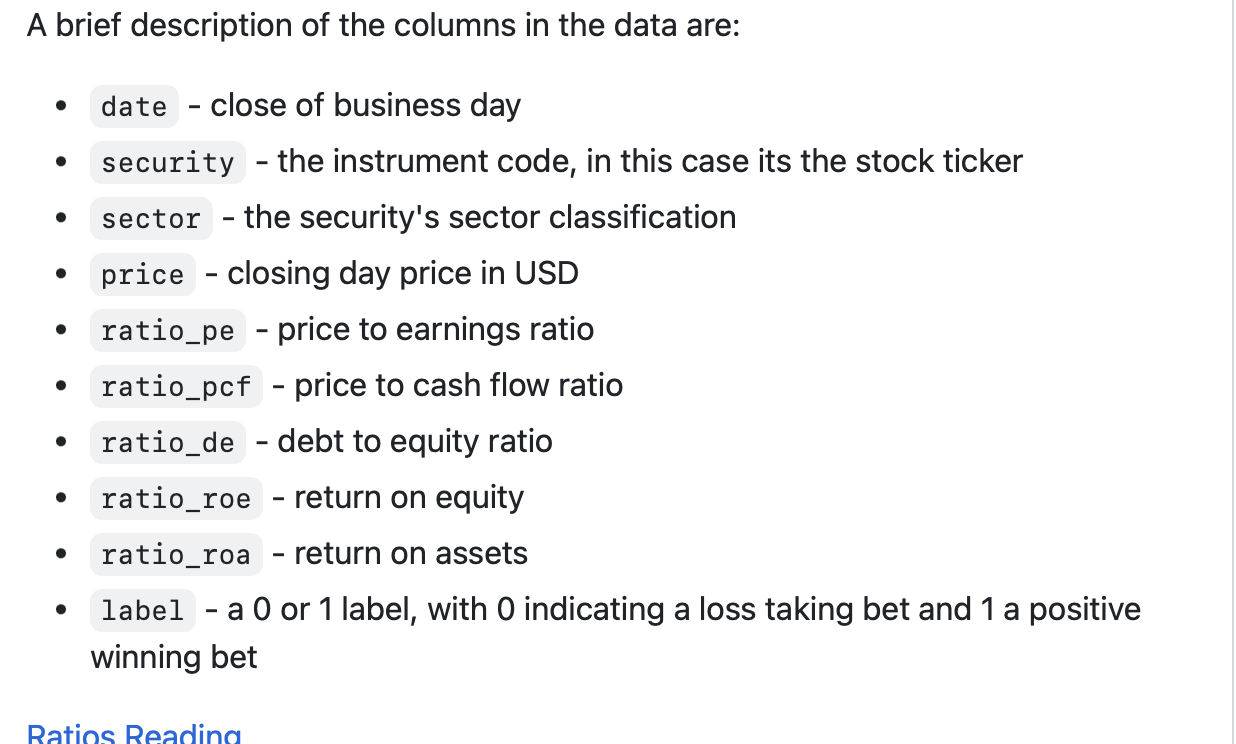

### <mark>ratio_pe</mark>
Price to earnings ratio
Measures how expensive a stock is relative to its earnings
$$
\frac {stockPrice}{earningsPerStock}
$$
A higher pe ratio can mean the comapny is over valued or expected to grow
<br><br>

### <mark>ratio_pcf</mark>
Price to cash flow ratio
$$
\frac {stockPrice}{OperatingCashFlow}
$$
Can provide a more straightforward comparision than PE ratio. This is because cash flow does not include noncash expenses. Eliminating these can help remove differences in how companies depreciate their assets.<br> Lower pcf is preferable 
<br><br>

### <mark>ratio_de</mark>
Debt to equity ratio
$$
\frac {totalDebt}{shareholdersEquity}
$$
This percentage tells you how much a company is financed with debt. Higher values can mean higher risk. However established companies normally have a higher debt equity ratio. Unlike rapidly growing companies.<br>Lower values are preferable
<br><br>

### <mark>ratio_roe</mark>
Return on equity ratio
$$
\frac {netIncome}{shareholdersEquity}
$$
Measures how efficiently a company generates profits from money invested in the company. Useful for measuring a companies effectiveness
<br><br>

### <mark>ratio_roa</mark>
Return on assets ratio
$$
\frac {netIncome}{totalAssets}
$$
Measures how efficiently a company generates profits from given base of assets. Companies with a low roa would have to borrow or raise equity to achive te same amount of profit.
Also useuful for measuring a companies effectiveness
<br><br>

### <mark>label</mark>
A 0 or 1 label.
$$
0 / 1
$$
Where 0 means the stock went down the following day and 1 means the stock went up the following day.
A loss taking bet and a positive winning taking bet

In [ ]:
#Load the data
